<h2 style='color:blue' align='center'>Celebrity Classification for Actor Recognition<h2>

In [15]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt

# Import necessary libraries for machine learning and data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report

# Import classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Enable inline plotting for Jupyter notebooks (if applicable)
%matplotlib inline

In [ ]:
# Load Haar Cascade classifiers
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [17]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [18]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [19]:
path_to_data = "./images/"
path_to_cr_data = "./images/cropped/"

In [49]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [50]:
img_dirs

['./images/cropped',
 './images/Denzel Washington',
 './images/Leonardo DiCaprio',
 './images/Robert Downey Jr',
 './images/Sandra Bullock',
 './images/Scarlett Johansson']

In [51]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [52]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./images/cropped/Denzel Washington
Generating cropped images in folder:  ./images/cropped/Leonardo DiCaprio
Generating cropped images in folder:  ./images/cropped/Robert Downey Jr
Generating cropped images in folder:  ./images/cropped/Sandra Bullock
Generating cropped images in folder:  ./images/cropped/Scarlett Johansson


In [53]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Denzel Washington': ['./images/cropped/Denzel Washington\\Denzel Washington1.png',
  './images/cropped/Denzel Washington\\Denzel Washington10.png',
  './images/cropped/Denzel Washington\\Denzel Washington100.png',
  './images/cropped/Denzel Washington\\Denzel Washington101.png',
  './images/cropped/Denzel Washington\\Denzel Washington102.png',
  './images/cropped/Denzel Washington\\Denzel Washington103.png',
  './images/cropped/Denzel Washington\\Denzel Washington104.png',
  './images/cropped/Denzel Washington\\Denzel Washington105.png',
  './images/cropped/Denzel Washington\\Denzel Washington106.png',
  './images/cropped/Denzel Washington\\Denzel Washington107.png',
  './images/cropped/Denzel Washington\\Denzel Washington108.png',
  './images/cropped/Denzel Washington\\Denzel Washington109.png',
  './images/cropped/Denzel Washington\\Denzel Washington11.png',
  './images/cropped/Denzel Washington\\Denzel Washington110.png',
  './images/cropped/Denzel Washington\\Denzel Washington111

In [54]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Denzel Washington': 0,
 'Leonardo DiCaprio': 1,
 'Robert Downey Jr': 2,
 'Sandra Bullock': 3,
 'Scarlett Johansson': 4}

### Let's prepare X and y to train the model

In [55]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [56]:
len(X[0])

4096

In [58]:
X[0]

array([[197],
       [226],
       [240],
       ...,
       [252],
       [250],
       [253]], dtype=uint8)

In [59]:
y[0]

0

In [60]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(647, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', svm.SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9074074074074074

In [63]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        33
           1       1.00      0.92      0.96        37
           2       0.87      0.91      0.89        22
           3       1.00      0.74      0.85        23
           4       0.90      0.91      0.91        47

    accuracy                           0.91       162
   macro avg       0.92      0.90      0.90       162
weighted avg       0.92      0.91      0.91       162



### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [65]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [66]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=10, return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(df)


                 model  best_score  \
0                  svm    0.851488   
1        random_forest    0.632781   
2  logistic_regression    0.872194   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}  


In [67]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [68]:
best_estimators['svm'].score(X_test,y_test)

0.9320987654320988

In [69]:
best_estimators['random_forest'].score(X_test,y_test)

0.6604938271604939

In [70]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.9259259259259259

In [77]:
best_clf = best_estimators['logistic_regression']

In [73]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[32,  1,  0,  0,  0],
       [ 0, 35,  2,  0,  0],
       [ 0,  1, 21,  0,  0],
       [ 0,  0,  2, 19,  2],
       [ 2,  1,  0,  0, 44]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

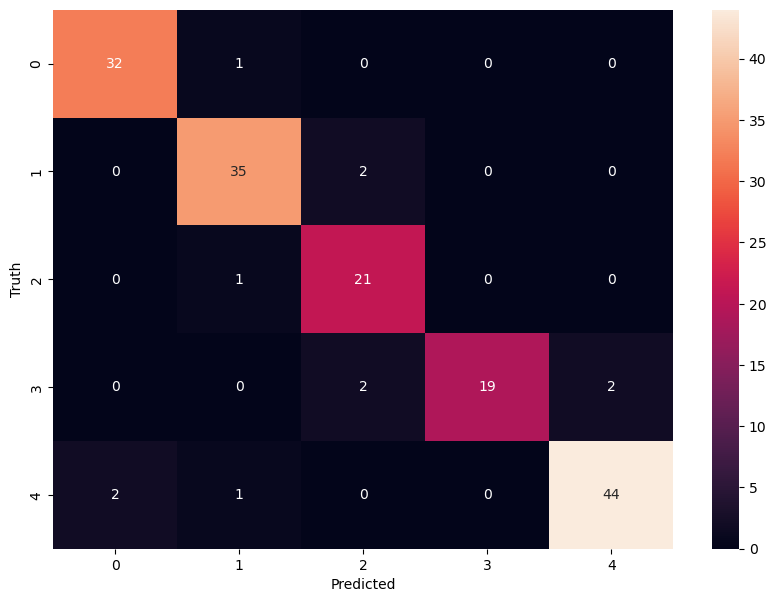

In [74]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [75]:
class_dict

{'Denzel Washington': 0,
 'Leonardo DiCaprio': 1,
 'Robert Downey Jr': 2,
 'Sandra Bullock': 3,
 'Scarlett Johansson': 4}

### Save the trained model

In [78]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [79]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))